# Siamese Network/ Contrasitve Loss
Embedding Netの出力が2次元の場合

# train_dataset, test_datasetを作成

In [1]:
import os
import os.path as osp
import glob
from PIL import Image
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms

In [2]:
CLASSES = ["bird", "cat", "deer", "dog", "frog", "horse"]
class Dataset(data.Dataset):
    def __init__(self, file_paths_list, transform, phase):
        self.file_paths_lsit = file_paths_list
        self.transform = transform
        self.train = True if phase=="train" else False
        
    def __len__(self):
        return len(self.file_paths_lsit)
    
    def __getitem__(self, index):
        # 読み込み
        path = self.file_paths_lsit[index]
        img = Image.open(path) # [高さ][幅][色RGB]
        
        # 前処理
        img_transformed = self.transform(img)
        
        # ラベル
        label = path.split("/")[4]
        label = CLASSES.index(label)
        
        return path, img_transformed, label

In [3]:
# ファイルのpathリスト作成
train_dataset_paths = "./dataset/cifar/train/*/*"
test_dataset_paths = "./dataset/cifar/test/*/*"

train_dataset_paths_list = [_ for _ in glob.glob(train_dataset_paths)]
test_dataset_paths_list = [_ for _ in glob.glob(test_dataset_paths)]

In [4]:
print("len(train_dataset_paths_list):", len(train_dataset_paths_list))
print("len(test_dataset_paths_list):", len(test_dataset_paths_list))

len(train_dataset_paths_list): 30000
len(test_dataset_paths_list): 4000


In [5]:
# 前処理
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
train_dataset = Dataset(train_dataset_paths_list, data_transforms, "train")

In [7]:
batch_size = 32
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [8]:
print("len(train_dataset):", len(train_dataset))

len(train_dataset): 30000


In [9]:
index = 12012
print("path :", train_dataset[index][0])
print("shape:", train_dataset[index][1].shape)
print("label:", train_dataset[index][2])

path : ./dataset/cifar/train/frog/23516_frog.png
shape: torch.Size([3, 32, 32])
label: 4


# ペアを返すデータセットの作成

In [10]:
train_labels = np.array([train_dataset[index][2] for index in range(len(train_dataset))])

In [11]:
train_labels

array([1, 1, 1, ..., 2, 2, 2])

In [12]:
class SiameseCIFAR(data.Dataset):
    def __init__(self, dataset, dataset_labels):
        self.train = dataset.train # flag
        self.dataset = dataset # dataset instance
        self.dataset_labels = dataset_labels # labels list
        if self.train:
            self.train_labels = self.dataset_labels
            self.labels_set = set(self.dataset_labels)
            self.labels_to_indices = {label : np.where(self.dataset_labels == label)[0] for label in self.labels_set} # key: label , value: labelのindeices
        else:
            pass
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if self.train:
            target = np.random.randint(0, 2) # 0 or 1, 
            path1, img1, label1 = self.dataset[index]
            if target == 1: # 同じラベルの違うデータを選択
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.labels_to_indices[label1])
            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.labels_to_indices[siamese_label])
            path2, img2, label2 = self.dataset[siamese_index]
        else:
            pass
        
        pair_paths = (path1, path2)
        pair_imgs = (img1, img2)
        pair_labels = (label1, label2)
        
        
        return (pair_paths, pair_imgs, pair_labels, target)

In [13]:
siamese_train_dataset = SiameseCIFAR(train_dataset, train_labels)

In [14]:
print("paths:", siamese_train_dataset[0][0])
print("shapes: ", siamese_train_dataset[0][1][0].shape, siamese_train_dataset[0][1][1].shape)
print("labels: ", siamese_train_dataset[0][2])

paths: ('./dataset/cifar/train/cat/12013_cat.png', './dataset/cifar/train/cat/6674_cat.png')
shapes:  torch.Size([3, 32, 32]) torch.Size([3, 32, 32])
labels:  (1, 1)


In [15]:
batch_size = 64
siamese_train_loader = data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True)

In [16]:
for batch_idx, a in enumerate(siamese_train_loader):
    print("paths:", a[0])
    print("shapes:", a[1])
    print("labels:", a[2])
    print("targets:", a[3])
    break

paths: [('./dataset/cifar/train/horse/48456_horse.png', './dataset/cifar/train/cat/24817_cat.png', './dataset/cifar/train/horse/45127_horse.png', './dataset/cifar/train/bird/19056_bird.png', './dataset/cifar/train/bird/45229_bird.png', './dataset/cifar/train/dog/12716_dog.png', './dataset/cifar/train/deer/20553_deer.png', './dataset/cifar/train/dog/45983_dog.png', './dataset/cifar/train/dog/5372_dog.png', './dataset/cifar/train/deer/46021_deer.png', './dataset/cifar/train/bird/7633_bird.png', './dataset/cifar/train/bird/3626_bird.png', './dataset/cifar/train/bird/17188_bird.png', './dataset/cifar/train/cat/16526_cat.png', './dataset/cifar/train/cat/25547_cat.png', './dataset/cifar/train/bird/14146_bird.png', './dataset/cifar/train/bird/19225_bird.png', './dataset/cifar/train/cat/19578_cat.png', './dataset/cifar/train/bird/39242_bird.png', './dataset/cifar/train/cat/16271_cat.png', './dataset/cifar/train/frog/24275_frog.png', './dataset/cifar/train/horse/10170_horse.png', './dataset/cif

# EmbeddingNetの設定

In [17]:
class EmbeddingNet(nn.Module):
    """ Basic Embedding Network
    """
    def __init__(self, fc_input_size=64*6*6):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    nn.Conv2d(32, 64, 3),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    )
        self.fc = nn.Sequential(nn.Linear(fc_input_size, 256),
                                nn.ReLU(),
                                nn.Linear(256, 64),
                                nn.Linear(64, 2),
                                )
    
    def forward(self, x):
        """ convnet -> flatten -> fc 
            input: torch.Size([batch_size, 3, 64, 64])
            output: torch.Size([batch_size, 64])
        """
        x = self.convnet(x)
        batch_size = x.size(0)
        x = x.view(batch_size, -1) # flatten
        x = self.fc(x)
        return x


class EmbeddingNetL2(EmbeddingNet):
    """ output l2 norm
    """
    def __init__(self):
        super(EmbeddingNetL2, self).__init__()

    def forward(slef, x):
        x = super(EmbeddingNetL2, self).forward(x)
        x /= x.pow(2).sum(1, keepdim=True).sqrt()
        return x

In [18]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net
    
    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2
    
    def get_embedding(self, x):
        return self.embedding_net(x)

In [19]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9
        
    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)
        losses = 0.5 * (target.float() * distances + (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

In [20]:
margin = 1
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
model.to("cuda")
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs=50
log_interval=100

In [21]:
# fit(siamese_train_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, )

In [22]:
import time

# 時間計測開始
time_sta = time.perf_counter()

# fit 関数をそのまま書く
start_epoch = 0
losses = []
total_loss = 0

# train
for epoch in range(start_epoch, n_epochs):
    scheduler.step()
    model.train()
    losses = []
    total_loss = 0
    for batch_idx, (paths, datas, labels, targets) in enumerate(siamese_train_loader):
        x1, x2 = datas
        x1, x2 = x1.to("cuda"), x2.to("cuda")
        targets = targets.to("cuda")
        optimizer.zero_grad()
        outputs = model(x1, x2) # data = ([(x11, x12), (x21, x22), ....])
        output1, output2 = outputs
        loss = loss_fn(output1, output2, targets)
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    time_end = time.perf_counter()
    # 経過時間（秒）
    tim = time_end- time_sta
    print("epoch:", epoch, "loss:", loss.item(), "time:", tim)

/home/gesogeso/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


epoch: 0 loss: 0.13259300589561462 time: 22.98243737500161
epoch: 1 loss: 0.11161111295223236 time: 46.18292953699711
epoch: 2 loss: 0.15486836433410645 time: 69.32234345001052
epoch: 3 loss: 0.10901904106140137 time: 92.2914084859949
epoch: 4 loss: 0.1417231261730194 time: 115.25877679299447
epoch: 5 loss: 0.10547417402267456 time: 138.329719914007
epoch: 6 loss: 0.12734869122505188 time: 161.57783730499796
epoch: 7 loss: 0.12762460112571716 time: 184.81191916801617
epoch: 8 loss: 0.08807992935180664 time: 207.85181629401632
epoch: 9 loss: 0.10361437499523163 time: 230.86992710499908
epoch: 10 loss: 0.08732616901397705 time: 253.94769892800832
epoch: 11 loss: 0.07717365771532059 time: 276.9388780640147
epoch: 12 loss: 0.08333414793014526 time: 299.98211483701016
epoch: 13 loss: 0.11706932634115219 time: 323.04835348800407
epoch: 14 loss: 0.11052380502223969 time: 346.12812059599673
epoch: 15 loss: 0.09902282059192657 time: 369.19531012300286
epoch: 16 loss: 0.10455495119094849 time: 3

# Plot Embeddings

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
CLASSES = ["bird", "cat", "deer", "dog", "frog", "horse"]
classes_num = [i for i in range(len(CLASSES))]
colors = ["red", "blue", "pink", "orange", "yellow", "green"]
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(len(CLASSES)):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.xlim(ylim[0], ylim[1])
    plt.legend(CLASSES)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for paths, images, targets in dataloader:
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = targets.numpy()
            k += len(images)
    return embeddings, labels

In [24]:
model.cpu()
train_embeddings, train_labels = extract_embeddings(train_loader, model)

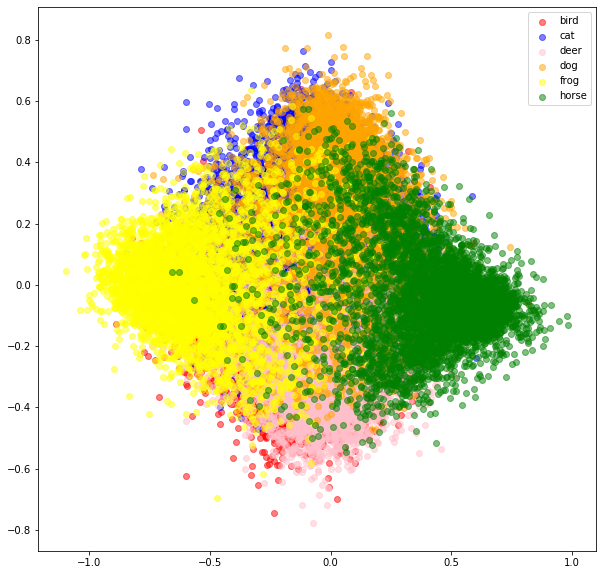

In [25]:
plot_embeddings(train_embeddings, train_labels)